In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/
root_path = 'gdrive/My Drive/'

import os
os.chdir('gdrive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
'5.Sequence models'
 apps.csv
 assets
'Aurélien Géron - Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_ Concepts, Tools, and Techniques to Build Intelligent Systems-O’Reilly Media (2019).pdf'
 best_model_custom.bin
 best_model_custom_v400.bin
 best_model_state.bin
'Colab Notebooks'
 David_Carricondo_Resume.pdf
'Documento sin título.gdoc'
 goodreads_reviews_clean.csv
 IH_careerpath
 IMG_20190624_004152.jpg
 model_1ltsm.h5
 model_2ltsm.h5

In [2]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 28.6MB/s 
     |████████████████████████████████| 890kB 40.1MB/s 
     |████████████████████████████████| 3.0MB 35.5MB/s 


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import json
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#To get an understandable traceback of cuda errors
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv("goodreads_reviews_clean.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,review,grade,lang,score,sentiment
0,I'll go 3.5 stars. It's a 600 page book and ne...,liked it,en,2,1
1,"""Some day I'll write a book about myself, abou...",liked it,en,2,1
2,Read as part of The Infinite Variety Reading C...,liked it,en,2,1
3,This is what Brett Easton Ellis has to say abo...,liked it,en,2,1
4,Actual Rating: 3.5 Stars,liked it,en,2,1


In [5]:
df.rename(columns={'review':'content'}, inplace=True)
df.head()

,content,grade,lang,score,sentiment
0,I'll go 3.5 stars. It's a 600 page book and ne...,liked it,en,2,1
1,"""Some day I'll write a book about myself, abou...",liked it,en,2,1
2,Read as part of The Infinite Variety Reading C...,liked it,en,2,1
3,This is what Brett Easton Ellis has to say abo...,liked it,en,2,1
4,Actual Rating: 3.5 Stars,liked it,en,2,1


Text(0.5, 0, 'Review score')

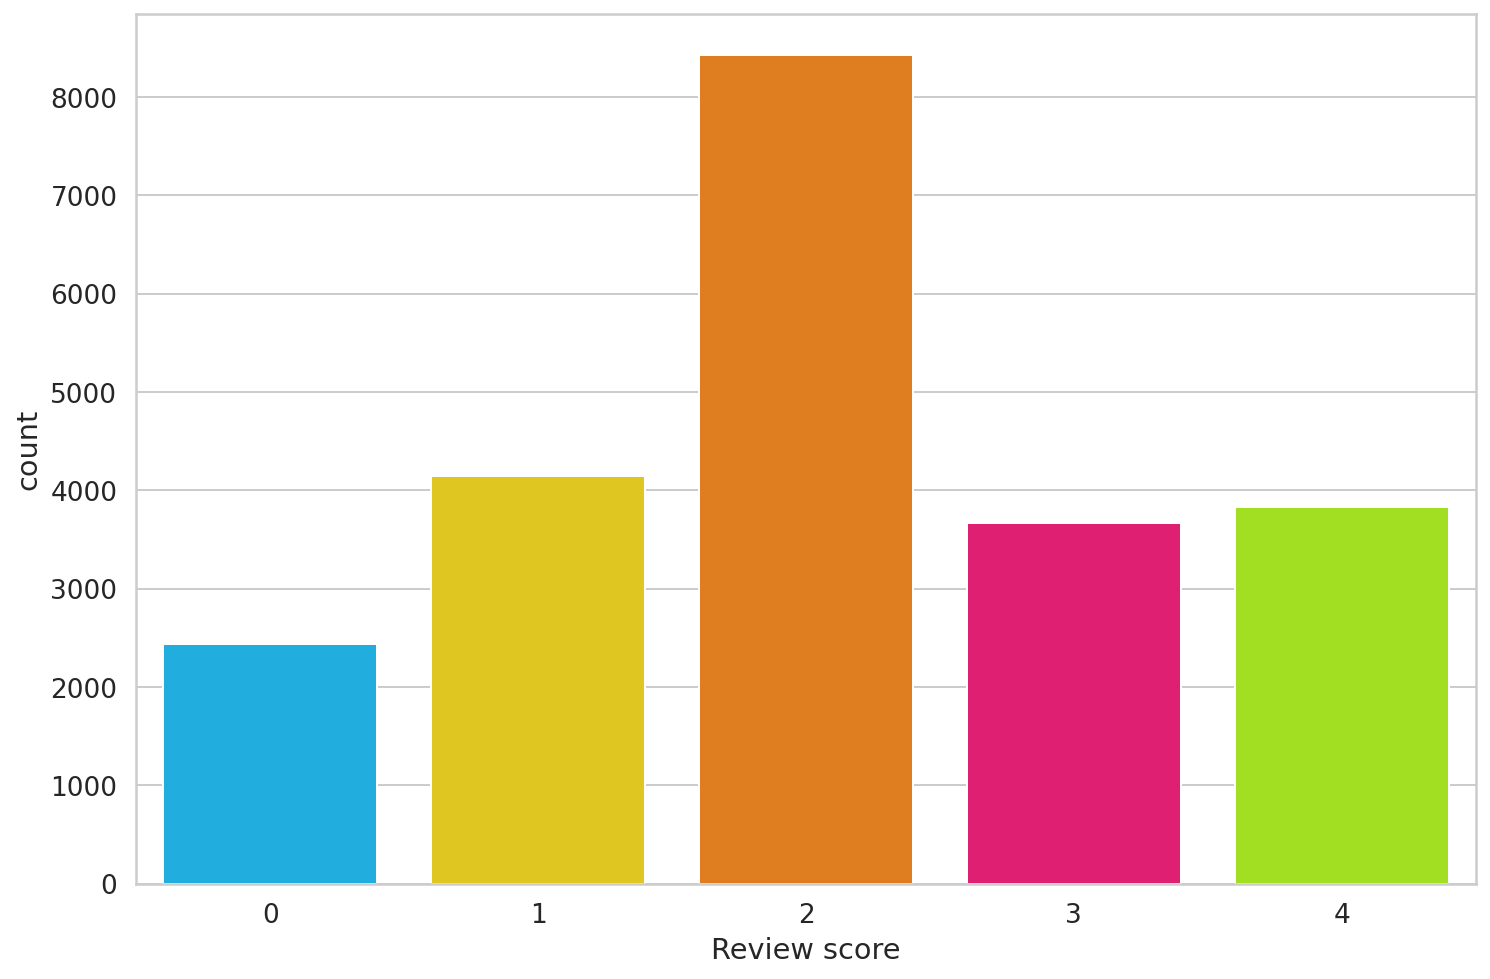

In [6]:
sns.countplot(df.score)
plt.xlabel('Review score')

Transform data into categorical 'positive', 'neutral', and 'negative' reviews:

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

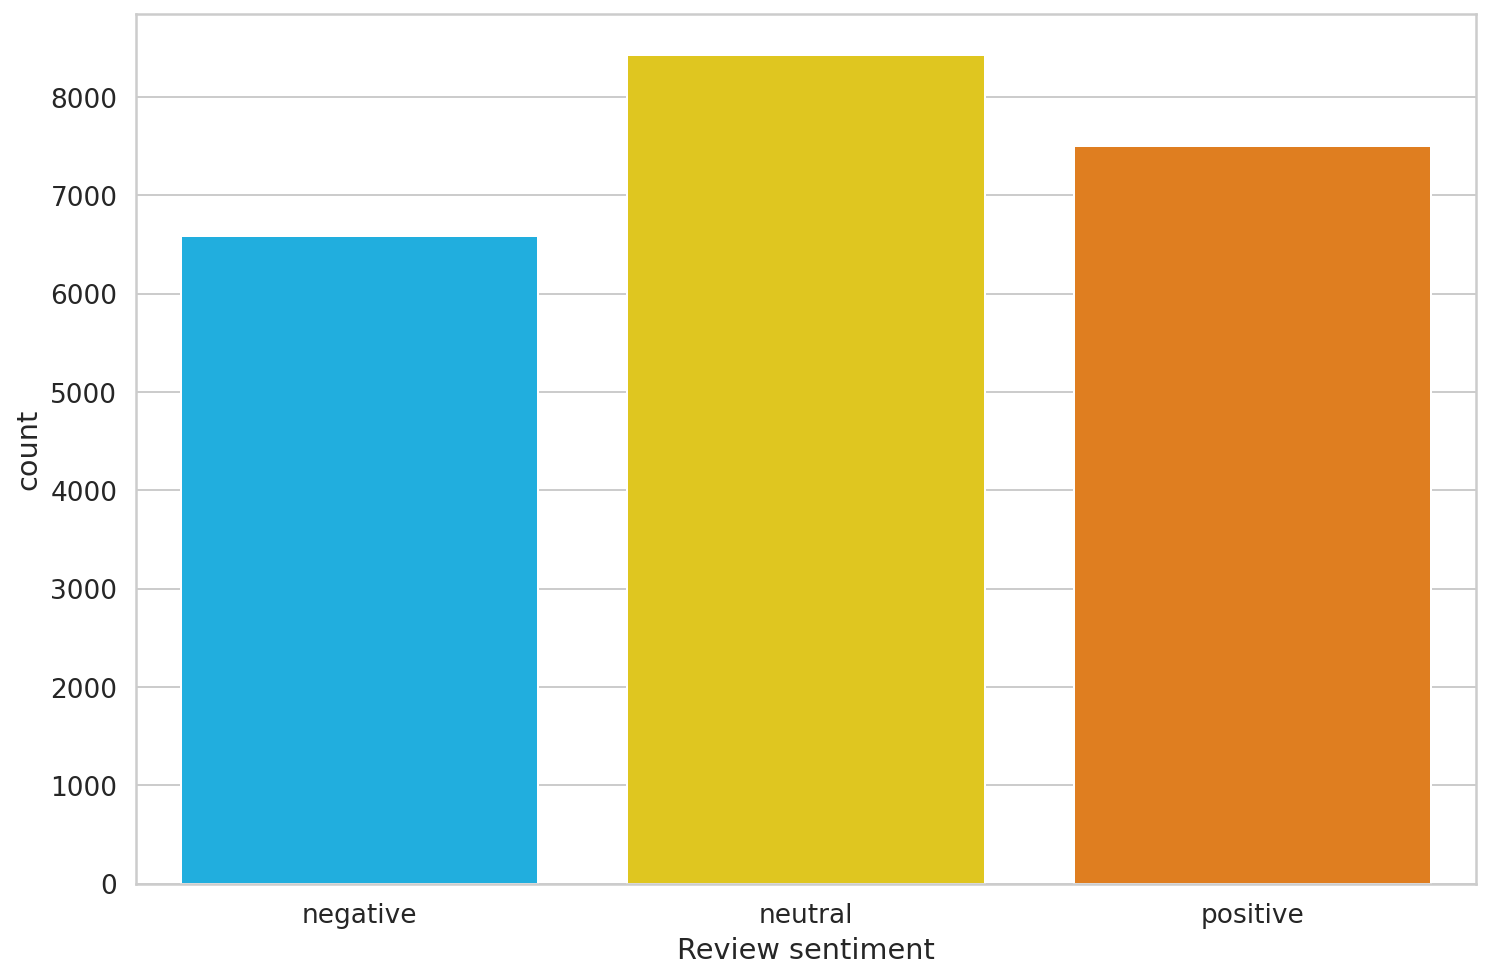

In [7]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('Review sentiment')
ax.set_xticklabels(class_names)

## Data preprocessing

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Here we use the pre-trained model bert case sensitive model, so words in uppercase have more emphasis and importance in the analysis (everybody knows that uppercase is just shouting in the internet...)

The module transformers have also a tokenizer for bert wich requires some special tokenization:
  - Separator tokens
  - Padding
  - Attention masks (arrays of 0 and 1s (padded and real tokens))
  

In [9]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Example:

In [10]:
sample = 'Mary had a lamb, a very nice one'

#Convert text to tokens
tokens = tokenizer.tokenize(sample)
#Convert the tokens to ids:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [11]:
print(f'Sentence: {sample}')
print(f'  Tokens: {tokens}')
print(f'     Ids: {token_ids}')

Sentence: Mary had a lamb, a very nice one
  Tokens: ['Mary', 'had', 'a', 'la', '##mb', ',', 'a', 'very', 'nice', 'one']
     Ids: [2090, 1125, 170, 2495, 12913, 117, 170, 1304, 3505, 1141]


We need to add the special tokens, namely [CLS] at the beggining of each sentence, [SEP] as a separator token between each sentence, and [UNK] as the unknown token for tokens outside of the training set.

We can use the encode_plus method for this:

In [12]:
encoding = tokenizer.encode_plus(
    sample, 
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt' #PyTorch tensors
)

In [13]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
encoding['input_ids']

tensor([[  101,  2090,  1125,   170,  2495, 12913,   117,   170,  1304,  3505,
          1141,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [15]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Mary',
 'had',
 'a',
 'la',
 '##mb',
 ',',
 'a',
 'very',
 'nice',
 'one',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Choosing the max length for the reviews dataset:

In [17]:
token_lens = []

for rev in df.content:
  tokens = tokenizer.encode(rev, max_length=700, truncation=True)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

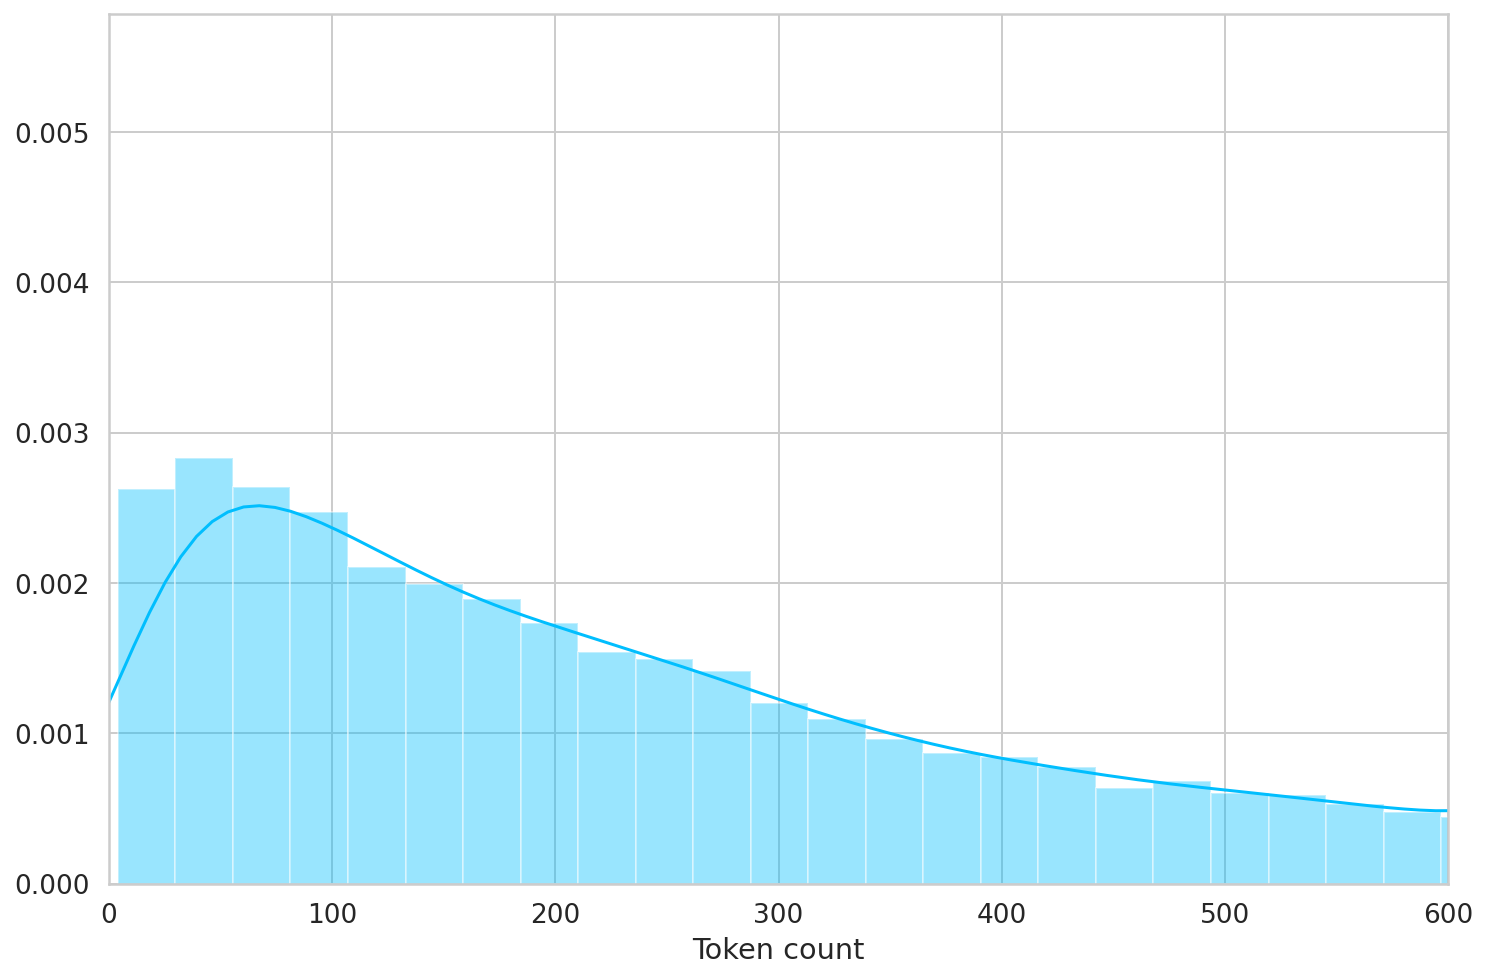

In [18]:
sns.distplot(token_lens)
plt.xlim([0,600])
plt.xlabel('Token count')

In [19]:
MAX_LEN = 500

Create a PyTorch dataset:

In [21]:
class GRReviewDataset(Dataset):
  
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    #The class mainly rely on the next lines:
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }


Now we can split the data into training, validation and test sets:

In [22]:
df_train, df_test = train_test_split(
    df, test_size=0.1, random_state=RANDOM_SEED)

df_val, df_test = train_test_split(
    df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((20260, 5), (1126, 5), (1126, 5))

Finally, we need a PyTorch dataloader:

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GRReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [26]:
print(data['input_ids'].shape)

print(data['attention_mask'].shape)

print(data['targets'].shape)

torch.Size([8, 500])
torch.Size([8, 500])
torch.Size([8])


##Modelling with the bert base model

In [27]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [28]:
#using the example text
last_hidden_State, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [29]:
last_hidden_State.shape

torch.Size([1, 32, 768])

In [30]:
bert_model.config.hidden_size

768

Let's create now a sentiment classifier starting from the last hidden state of the bert model:

In [31]:
class SentimentCLassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentCLassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids=input_ids, 
        attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Now we can create an instance of the model and run it in the GPU by using the method .to(device)

In [32]:
model = SentimentCLassifier(len(class_names))
model = model.to(device)

In [33]:
#To use the stored model:

model = SentimentCLassifier(len(class_names))
model.load_state_dict(torch.load('best_model_custom.bin'))
model = model.to(device)

Let's set up the training optimizer (AdamW which takes care of the weight decay in deep nn), the loss function and the number of epochs:

In [34]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [35]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  '''
  Function that train one epoch
  '''
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds==targets)
    losses.append(loss.item())

    loss.backward()
    #Here we use clipping gradients to avoid exploding gradients:
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)


THe next function is similar than the previous one but without the backpropagation, and therefore, is used for inference. We achieve this by using torch.no_grad()

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Now we can loop:

In [37]:
%%time

#Default dictionaries create a key if it does not exist when calling it
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch +1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model, 
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_custom_v500.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.44352380007187747 accuracy 0.8601184600197432
Val loss 1.4786624808049371 accuracy 0.6669626998223801

Epoch 2/10
----------
Train loss 0.3086545986534812 accuracy 0.9262092793682132
Val loss 1.7381139098012701 accuracy 0.6678507992895204

Epoch 3/10
----------
Train loss 0.2150345138155374 accuracy 0.9531589338598222
Val loss 2.039871669143227 accuracy 0.6705150976909414

Epoch 4/10
----------
Train loss 0.16371771632342577 accuracy 0.9677690029615005
Val loss 2.331506309357095 accuracy 0.6669626998223801

Epoch 5/10
----------
Train loss 0.12015279231573159 accuracy 0.977295162882527
Val loss 2.4206672665920665 accuracy 0.6678507992895204

Epoch 6/10
----------
Train loss 0.0833638663342288 accuracy 0.9846001974333661
Val loss 2.501113120123004 accuracy 0.674955595026643

Epoch 7/10
----------
Train loss 0.06041510717004267 accuracy 0.9891905231984205
Val loss 2.965995414882687 accuracy 0.6571936056838367

Epoch 8/10
----------
Train loss 0.04350207

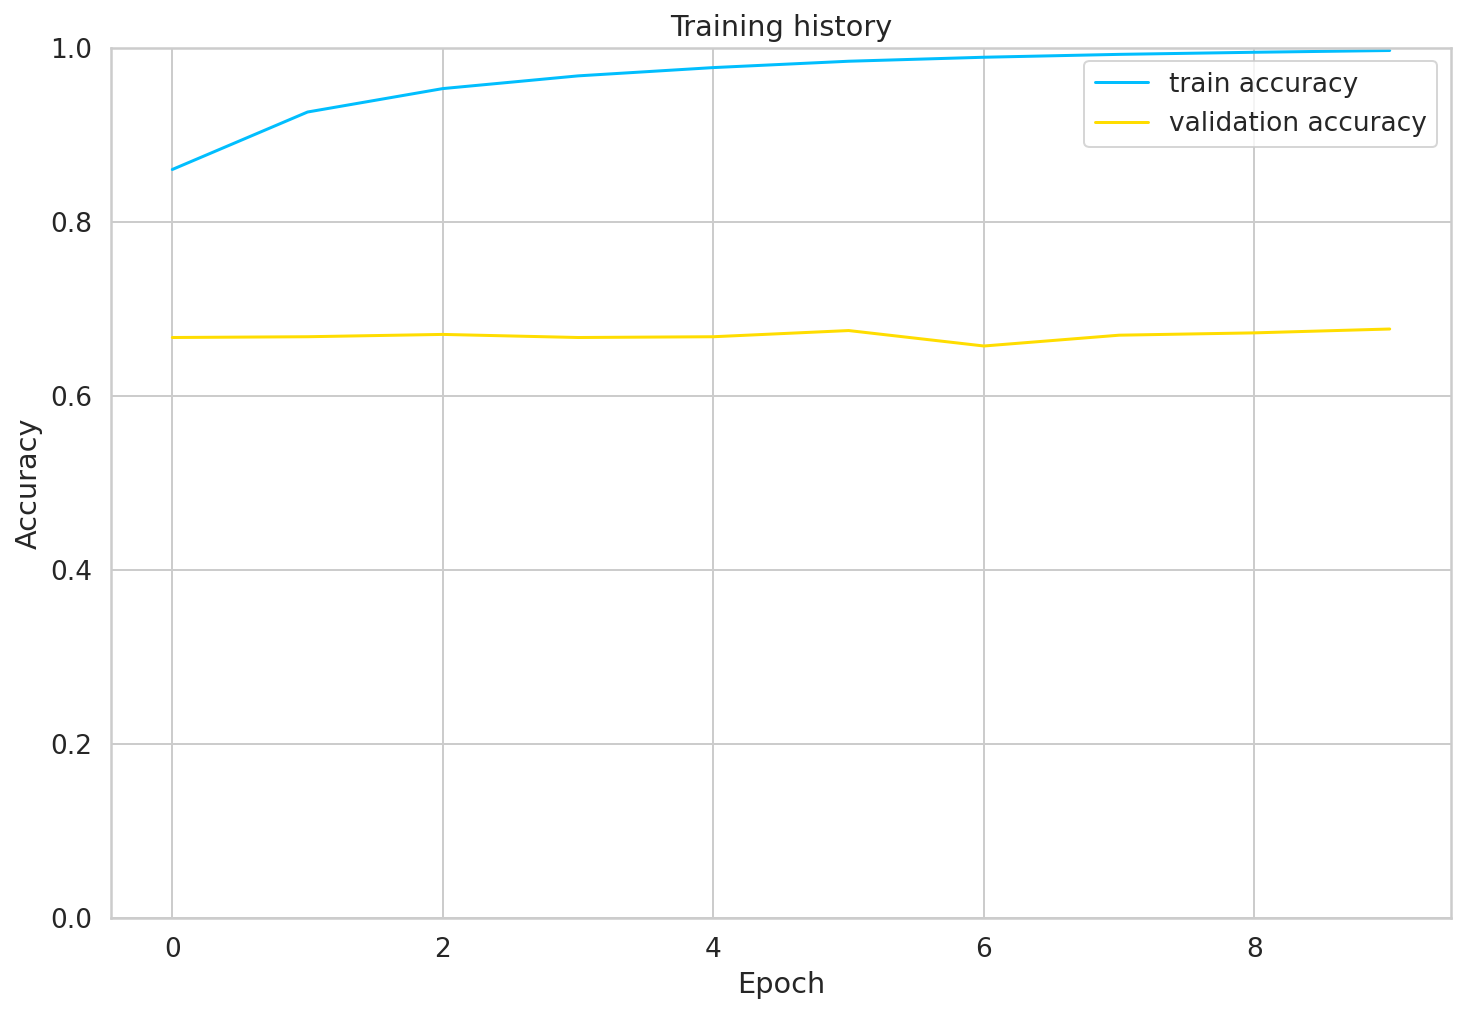

In [38]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

##Model evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test))

test_acc.item()

0.6989342806394316

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.71      0.78      0.74       328
     neutral       0.63      0.61      0.62       410
    positive       0.76      0.73      0.74       388

    accuracy                           0.70      1126
   macro avg       0.70      0.70      0.70      1126
weighted avg       0.70      0.70      0.70      1126



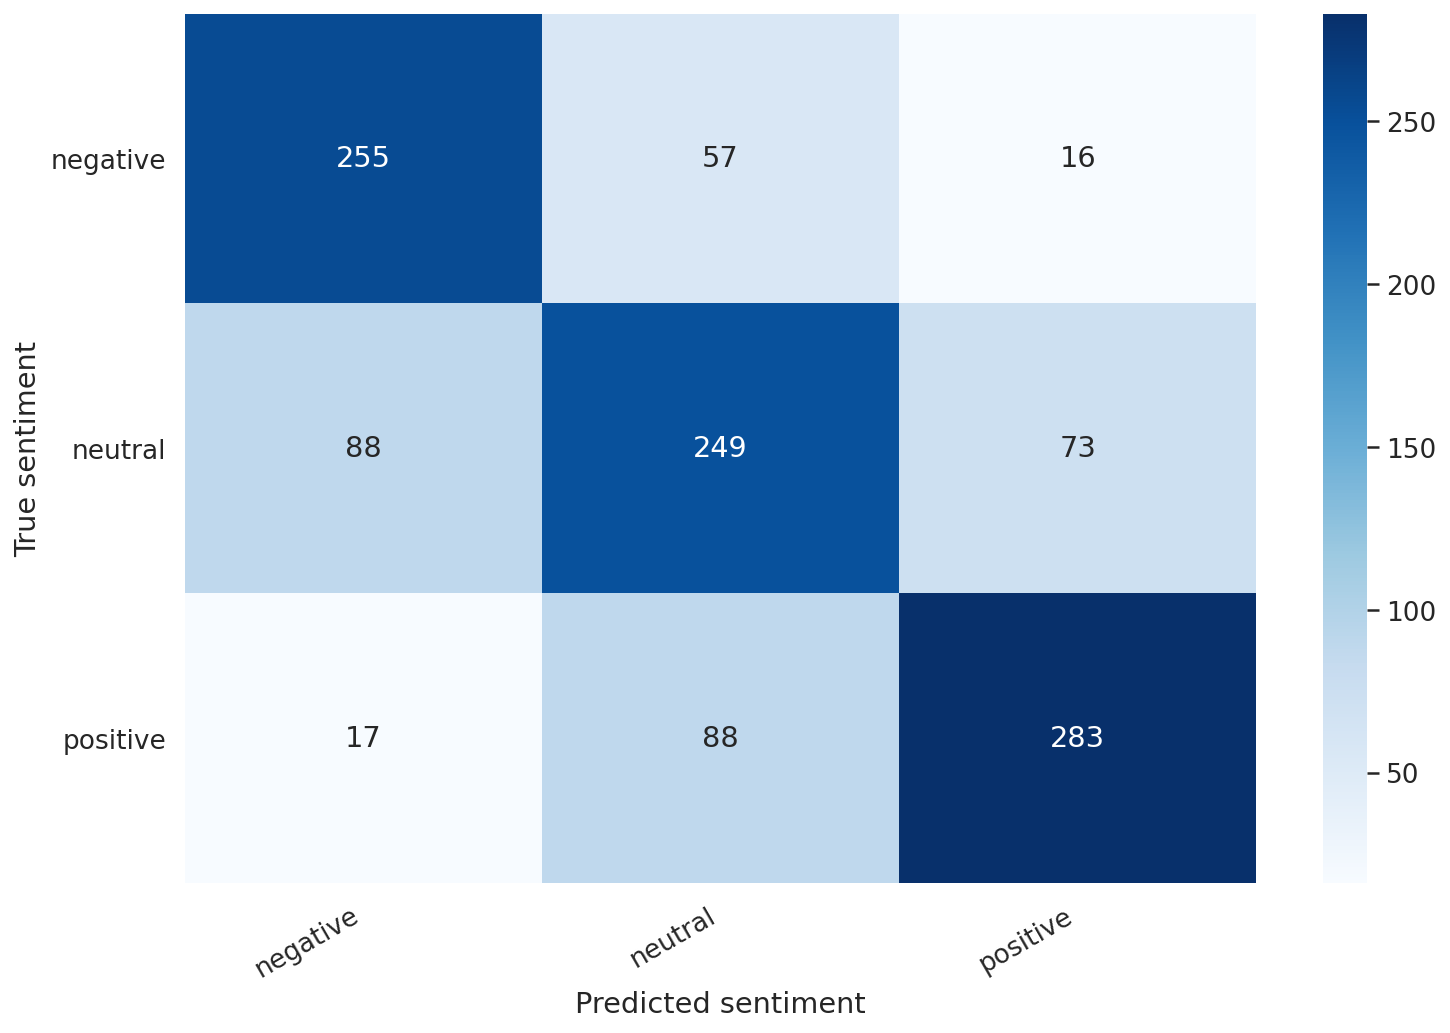

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
#Example from test data:
idx = 22

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

If you want to know what war is like, read/listen to this book. War is
Hell and this book gives evidence of it. It is overview but gives
description on what was it like to be in it. Hitler had to be stopped
and what a price was paid to stop him. Suffering of levels we could
not now comprehend. This book give broad look at the individuals and
how countries acted during the War. Have new respect for Scandinavian
countries, Denmark resistance movement was fierce more so than
France's resistance movement. The Danes hid more Jews than the French
also. World War 2 was not just about the Nazis against the Jews, the
Nazis were against everybody and although they killed many Jews, only
1 in 7 of who they killed were Jews. They wanted absolute power and
control of everything. The awful depths they went to, the hubris of
Hitler thinking he could march thousand miles into Russia a conqueror,
defies explanation. No country should every worship their leader,
Ever. If one wants to understand why read

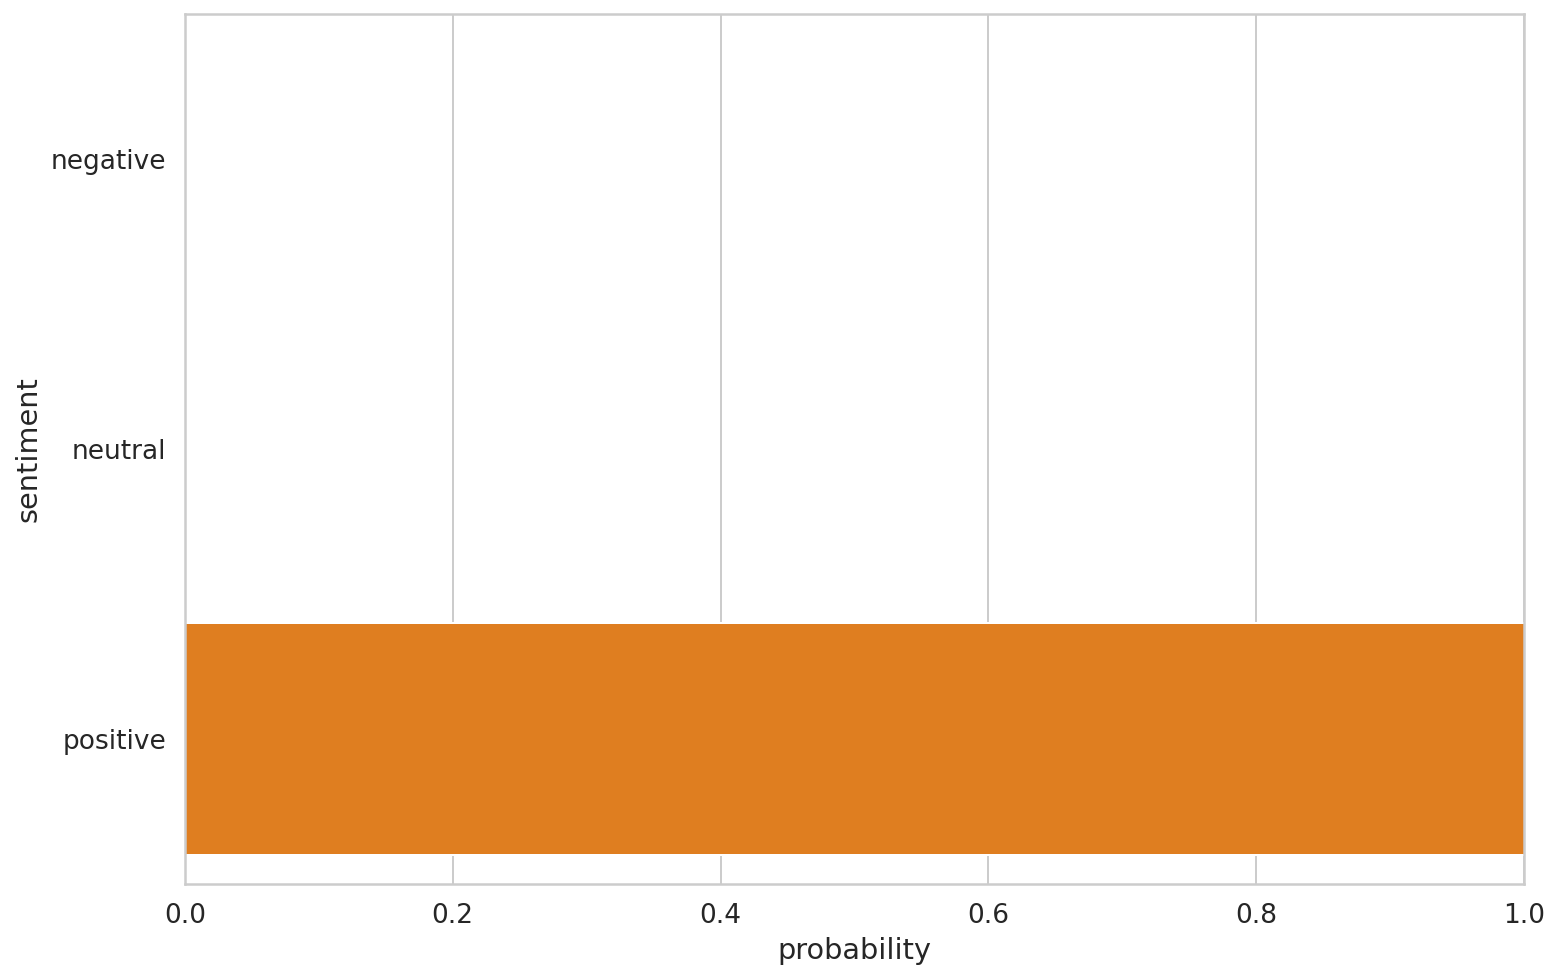

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
#Raw data: 

review_text = 'All the apps suck, except for this one'

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')

print(f'Sentiment  : {class_names[prediction]}')

Review text: All the apps suck, except for this one
Sentiment  : negative
